In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os 
import cv2
import tensorflow as tf
from keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow import reduce_mean
from tensorflow.keras.losses import Reduction
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [52]:
main_path='/kaggle/input/multi-modal-from-spacenet6/DataSet'
RGB_IMAGE = []
SAR_IMAGE=[]
for i in os.listdir(main_path):
    dir_path=main_path+'/'+i
    for ii in os.listdir(dir_path):
        if ii.split('/')[-1].split('.')[0]=='SAR-Intensity':
            SAR_IMAGE.append(dir_path+'/'+ii)
        if ii.split('/')[-1].split('.')[0]=='PS-RGB':
            RGB_IMAGE.append(dir_path+'/'+ii)

In [53]:
main_dir = '/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/'
for sub_dir in os.listdir(main_dir):
    for i in sorted(os.listdir(main_dir+sub_dir)):
        folders = main_dir+sub_dir+'/'+i
        if i == 's1':
            for j in sorted(os.listdir(folders)):
                SAR_IMAGE.append(folders+'/'+j)
        if i == 's2':
            for j in sorted(os.listdir(folders)):
                RGB_IMAGE.append(folders+'/'+j)


In [54]:
final_df = pd.DataFrame()
final_df['RGB_IMAGE']=RGB_IMAGE
final_df['SAR_IMAGE']=SAR_IMAGE

In [94]:
final_df = final_df.sample(frac = 1)

In [56]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=6, dim=(224, 224), n_channels=3, shuffle=True):

        self.data = data
        self.indices = self.data.index.tolist()
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.on_epoch_end()
        self.n = len(data)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size

        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch)

        return x, y

    def on_epoch_end(self):

        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, RGB_IMAGE, SAR_IMAGE):
        
        RGB_IMAGE = cv2.imread(RGB_IMAGE)
        RGB_IMAGE = cv2.cvtColor(RGB_IMAGE, cv2.COLOR_BGR2RGB)
        RGB_IMAGE = cv2.resize(RGB_IMAGE, self.dim)
        RGB_IMAGE = tf.image.convert_image_dtype(RGB_IMAGE, tf.float32)

        SAR_IMAGE = cv2.imread(SAR_IMAGE)
        SAR_IMAGE = cv2.cvtColor(SAR_IMAGE, cv2.COLOR_BGR2RGB)
        SAR_IMAGE = cv2.resize(SAR_IMAGE, self.dim)
        SAR_IMAGE = tf.image.convert_image_dtype(SAR_IMAGE, tf.float32)
        

        return SAR_IMAGE, RGB_IMAGE

    def data_generation(self, batch):

        x = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))

        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(
                self.data["RGB_IMAGE"][batch_id],
                self.data["SAR_IMAGE"][batch_id],
            )

        return x, y

In [83]:
BATCH_SIZE=16
HEIGHT=128
WIDTH=HEIGHT
CHANNEL = 3

train_loader = DataGenerator(
    data=final_df[:17000].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)

validation_loader = DataGenerator(
    data=final_df[17000:].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)

In [84]:

class Losses:
    def __init__(self):
        pass
    
    def bce_loss(self, real, pred):
        bce = BinaryCrossentropy(reduction=Reduction.NONE)
        loss = bce(real, pred)
        loss = reduce_mean(loss)
        return loss
    
    
    def rmse_loss(self, real, pred):
        rmse = tf.reduce_mean(tf.abs(real - pred)**2)
        loss = reduce_mean(rmse)
        return loss
    
    def ssim_loss(self, real, pred):
        ssim = tf.image.ssim(real, pred, 1.0)
        return 1.0-tf.reduce_mean(ssim)
    
    def psnr_loss(self, real, pred):
        return tf.image.psnr(
           real, pred, max_val=1.0, name=None
        )

    def total_loss(self,real, pred):
        return ((self.bce_loss(real, pred)*0.9)+(self.rmse_loss(real, pred)*0.9)+(self.ssim_loss(real, pred)*0.2))
        return self.bce_loss(real, pred)+self.rmse_loss(real, pred)+self.ssim_loss(real, pred)

class Metrics:
    def __init__(self):
        def __init__(self):
            pass
        
    def  SSIM(self, y_true, y_pred):
        ssim = tf.image.ssim(y_true, y_pred, 1.0)
        return tf.reduce_mean(ssim)
    
    def PSNR(self, y_true, y_pred):  
        return tf.image.psnr(
           y_true, y_pred, max_val=1.0, name=None
        )


losses = Losses()
metrics = Metrics()

# UNET

In [85]:
kernel_size=(5,5)

class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=kernel_size, padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p


class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=kernel_size, padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x

In [86]:
bce = tf.keras.losses.BinaryCrossentropy()


class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.ssim_loss_weight = 0.2
        self.l2_loss_weight = 0.9
    
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        
        f = [32, 64, 128, 256,512,1024]
#         f=[8, 16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
            DownscaleBlock(f[4]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[5])
        self.upscale_blocks = [
            UpscaleBlock(f[4]),
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
            
        ]
        self.conv_layer = layers.Conv2D(3, (1, 1), padding="same", activation="sigmoid")

    def calculate_loss(self, target, pred):

        ssim_loss = tf.reduce_mean(
            1.0
            - tf.image.ssim(
                target, pred, max_val=1.0, filter_size=5
            )
        )

        l1_loss = tf.reduce_mean(tf.abs(target - pred)**2)
        
        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l2_loss_weight * l1_loss)
            + tf.reduce_mean(bce(target, pred))
        )

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):

        input_, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input_, training=True)
            loss = self.calculate_loss(target, pred)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
 
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input_, target = batch_data

        pred = self(input_, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)
        c5, p5 = self.downscale_blocks[4](p4)

        bn = self.bottle_neck_block(p5)
        
        u1 = self.upscale_blocks[0](bn, c5)
        u2 = self.upscale_blocks[1](u1, c4)
        u3 = self.upscale_blocks[2](u2, c3)
        u4=  self.upscale_blocks[3](u3, c2)
        u5 = self.upscale_blocks[4](u4, c1)

        return self.conv_layer(u5)

In [87]:
LR = 0.00001

optimizer = tf.keras.optimizers.RMSprop(learning_rate=LR)

model = DepthEstimationModel()

model.compile(optimizer, 
              loss=[losses.total_loss],
              metrics=metrics.PSNR
             )

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
#                                                  min_delta = 1e-4,
                                                 patience = 5,
                                                 restore_best_weights = True,
                                                 verbose = 1,
                                                mode='min',)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = f"/kaggle/working/unet_models.h5",
                                                  monitor = 'val_loss',
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                 mode='min',)

callbacks = [earlystopping, checkpointer]


model.fit(
    train_loader,
    epochs=30,
    validation_data=validation_loader,
    callbacks=callbacks
)

Epoch 1/30
1063/1063 [==============================] - 373s 344ms/step - loss: 0.8559 - val_loss: 0.8243

Epoch 00001: val_loss improved from inf to 0.82432, saving model to /kaggle/working/unet_models.h5
Epoch 2/30
1063/1063 [==============================] - 315s 296ms/step - loss: 0.8253 - val_loss: 0.8261

Epoch 00002: val_loss did not improve from 0.82432
Epoch 3/30
1063/1063 [==============================] - 309s 290ms/step - loss: 0.8166 - val_loss: 0.8021

Epoch 00003: val_loss improved from 0.82432 to 0.80206, saving model to /kaggle/working/unet_models.h5
Epoch 4/30
1063/1063 [==============================] - 294s 277ms/step - loss: 0.8041 - val_loss: 0.7916

Epoch 00006: val_loss improved from 0.79588 to 0.79162, saving model to /kaggle/working/unet_models.h5
Epoch 7/30
1063/1063 [==============================] - 308s 289ms/step - loss: 0.8004 - val_loss: 0.7899

Epoch 00007: val_loss improved from 0.79162 to 0.78991, saving model to /kaggle/working/unet_models.h5
Epoch 

KeyboardInterrupt: 

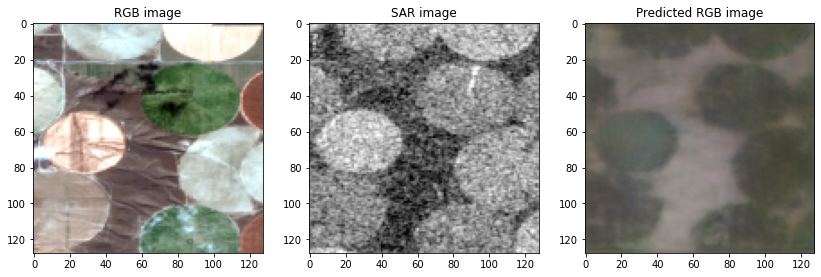

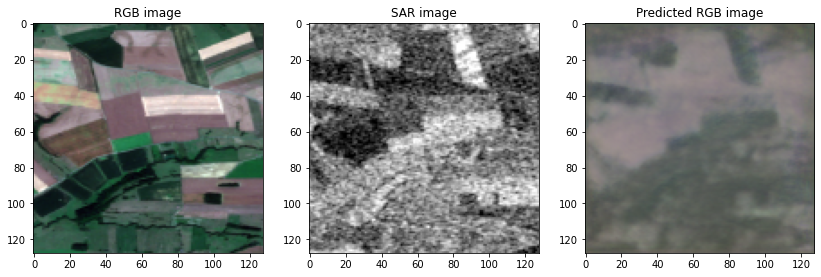

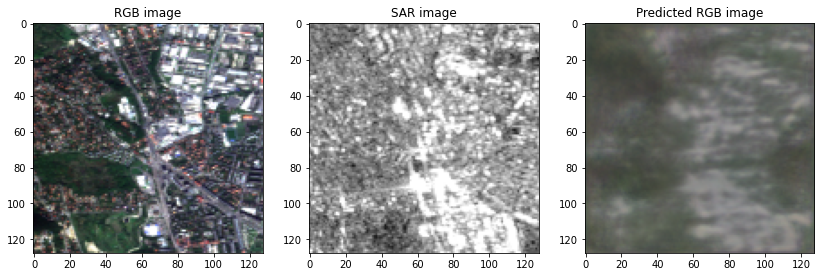

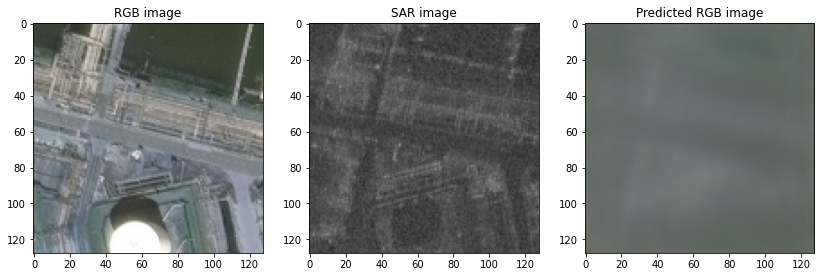

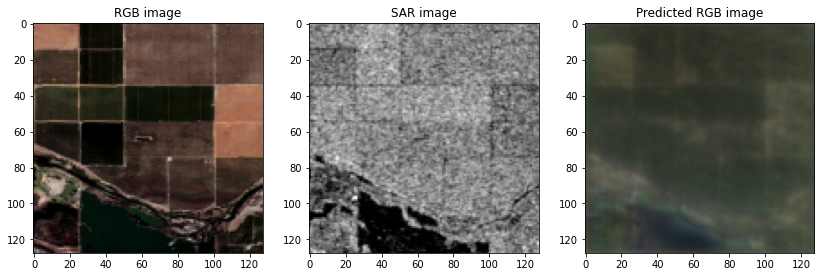

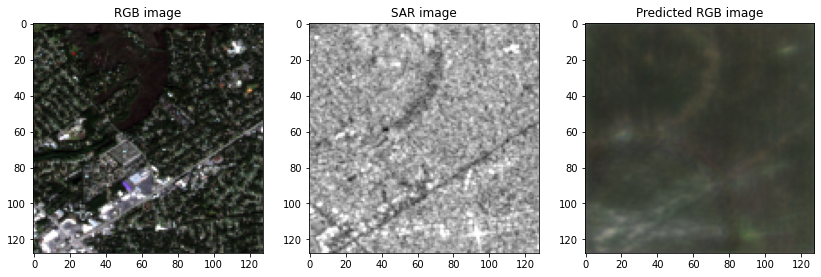

In [93]:
k=0
for i in validation_loader:
   
    pred = model.predict(i[0])

    fig = plt.figure(figsize=(14,7))
    plt.subplot(1, 3, 1).set_title('RGB image')
    plt.imshow(i[1][0])

    plt.subplot(1, 3, 2).set_title('SAR image')
    plt.imshow(i[0][0])
    
    plt.subplot(1, 3, 3).set_title('Predicted RGB image')
    plt.imshow(pred[0])
    plt.show()
    if k==5:
        break
    k+=1
fig.savefig('full_figure.png')